In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
import numpy as np

In [4]:
from itertools import cycle

In [5]:
import imageio

In [6]:
# Set use_cuda=True to use an available GPU
use_cuda=False

Text(0.5, 0, 'Input')

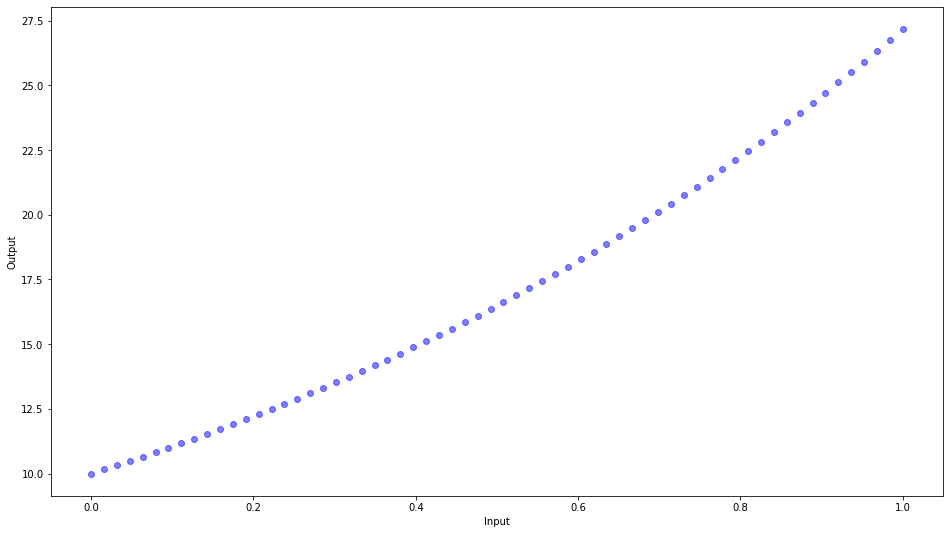

In [7]:
x = torch.unsqueeze(torch.linspace(0.0, 1.0, 64, requires_grad=True), dim=1)

if use_cuda:
    x = x.cuda()

y = 10 * torch.exp(1 * x)

x = Variable(x, requires_grad=True)
y = Variable(y, requires_grad=True)

x.retain_grad()

fig, axis = plt.subplots(figsize=(16,9))

axis.scatter(x.cpu().data.numpy(), y.cpu().data.numpy(),
             color='blue', alpha=0.5)

axis.set_ylabel("Output")
axis.set_xlabel("Input")

In [8]:
class HiddenNet(nn.Module):
    def __init__(self, n_independent, n_dependent,
                 n_hidden, hidden_depth, activation):
        super(HiddenNet, self).__init__()
        
        self.activation = activation
        self.input_layer = nn.Linear(n_independent, n_hidden)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_depth):
            self.hidden_layers.append(nn.Linear(n_hidden, n_hidden))
        self.output_layer = nn.Linear(n_hidden, n_dependent)
        
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for h in self.hidden_layers:
            x = self.activation(h(x))
        x = self.output_layer(x)
        return x

In [9]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.a = torch.nn.Parameter(torch.tensor(5.0))
        self.b = torch.nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        return self.a * torch.exp(self.b * x)
        #return self.a * x + self.b

In [10]:
#net = SimpleNet()

In [11]:
net = HiddenNet(n_independent=1, n_dependent=1,
                n_hidden=2, hidden_depth=4, activation=F.celu)

In [12]:
if use_cuda:
    net.cuda()

In [13]:
print(net)

HiddenNet(
  (input_layer): Linear(in_features=1, out_features=2, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Linear(in_features=2, out_features=2, bias=True)
  )
  (output_layer): Linear(in_features=2, out_features=1, bias=True)
)


In [14]:
optimizer_sgd = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer_adam = torch.optim.Adam(net.parameters(), lr=0.01)

In [15]:
optimizers = cycle([optimizer_sgd, optimizer_adam])

In [16]:
loss_func = torch.nn.MSELoss()

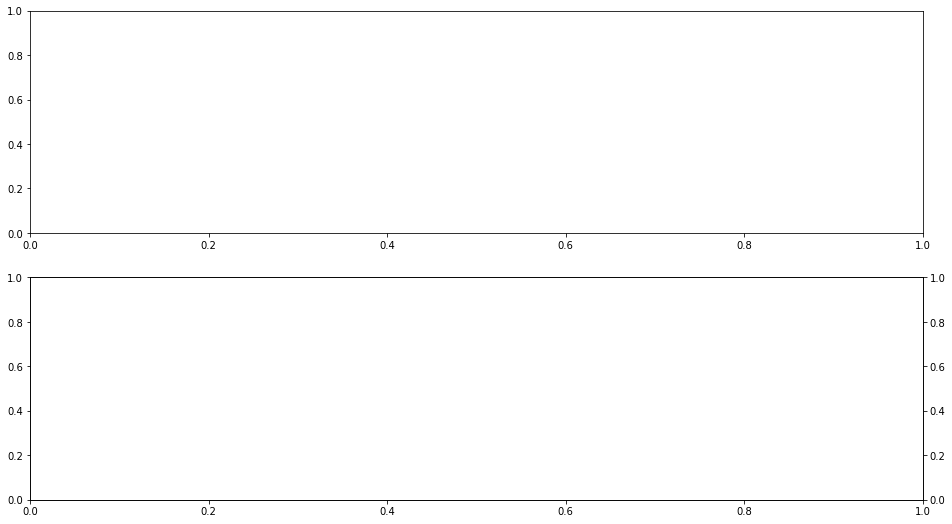

In [17]:
training_images = []
# get a multipanel figure showing the prediction (p) and error (e)
fig, (axis_p, axis_e) = plt.subplots(nrows=2, ncols=1, figsize=(16,9))
axis_e1 = axis_e.twinx()

In [18]:
epochs = []
losses = []
losses0 = []
losses1 = []

In [19]:
def train_error(NumEpochs):
    for t in range(NumEpochs):
        # calculate prediction given the current net state
        prediction = net(x)

        # calculate loss between prediction and reference y
        loss0 = torch.sqrt(loss_func(prediction, y))

        # calculate gradients d(prediction)/d(input)
        # y = a*exp(x), so d^k y(x)/dx^k = y(x)

        # first, zero out the existing gradients to avoid
        # accumulating gradients on top of existing gradients
        net.zero_grad()
        if x.grad is not None:
            x.grad.data.zero_()

        # now get the gradients dp/dx
        prediction.backward(torch.ones_like(prediction), retain_graph=True)
        dpdx = x.grad

        loss1 = torch.sqrt(loss_func(dpdx, y))

        loss = loss0 + loss1

        # switch between optimizers every 100 steps
        #if t % 100 == 0:
        #    optimizer = next(optimizers)
        optimizer = optimizer_adam

        # clear gradients for the next training iteration
        optimizer.zero_grad()

        # compute backpropagation gradients
        loss.backward()

        # apply gradients to update the weights
        optimizer.step()

        # generate plots
        if t % (NumEpochs//1000) == 0:
            # Prediction plot to show learning progress
            axis_p.clear()

            axis_p.set_title('Regression Progress', fontsize=36)
            axis_p.set_xlabel('Independent Variable', fontsize=22)
            axis_p.set_ylabel('Dependent Variable', fontsize=22)

            axis_p.scatter(x.cpu().data.numpy(), y.cpu().data.numpy(),
                           color="orange", alpha=0.75)
            axis_p.plot(x.cpu().data.numpy(), prediction.cpu().data.numpy(),
                        'g-', lw=3, alpha=0.75)

            # get min/max in x/y to set label positions relative to the axes
            ymin = np.min(y.cpu().detach().numpy())
            ymax = np.max(y.cpu().detach().numpy())
            height = np.abs(ymax - ymin)
            xmin = np.min(x.cpu().detach().numpy())
            xmax = np.max(x.cpu().detach().numpy())
            width = np.abs(xmax - xmin)

            axis_p.set_xlim(xmin, xmax)
            axis_p.set_ylim(ymin, ymax)

            axis_p.text(xmax - width*0.2, ymin + height*0.3,
                      'Step = %d' % t, fontdict={'size': 24, 'color': 'blue'})
            axis_p.text(xmax - width*0.2, ymin + height*0.1,
                      'Loss = %.2e' % loss.cpu().data.numpy(),
                      fontdict={'size': 24, 'color': 'blue'})

            axis_p.tick_params(axis='both', which='major', labelsize=16)

            # Error plot over time
            if not epochs:
                epochs.append(t)
            else:
                epochs.append(epochs[-1]+1)

            losses.append(loss.cpu().data.numpy())
            losses0.append(loss0.cpu().data.numpy())
            losses1.append(loss1.cpu().data.numpy())

            axis_e.clear()
            axis_e1.clear()

            axis_e.set_xlabel('Epoch', fontsize=22)
            axis_e.set_ylabel('Error 0', fontsize=22)

            axis_e.scatter([epochs[-1]], [losses0[-1]],
                           color="red", alpha=0.75)
            axis_e.plot(epochs, losses0,
                        'b-', lw=3, alpha=0.75)

            axis_e1.set_ylabel('Error 1', fontsize=22)

            axis_e1.scatter([epochs[-1]], [losses1[-1]],
                           color="red", alpha=0.75)
            axis_e1.plot(epochs, losses1,
                         'g-', lw=3, alpha=0.75)

            axis_e.tick_params(axis='both', which='major', labelsize=16)
            axis_e1.tick_params(axis='both', which='major', labelsize=16)

            # Draw on canvas and save image in sequence
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            training_images.append(image)

            # Print epoch/error notifications
            if t % (NumEpochs//100) == 0:
                print('epoch ', t, ' with error: ', losses[-1])
           
        # Stop early if our errors are plateauing
        if t > 1000:
            # do a quadratic polynomial fit and see if we will
            # need more than NumEpochs for the error e to vanish:
            # e / (d(e)/d(epoch)) > NumEpochs ?
            # if so, then break out of the training loop ...
            xfit = epochs[-4:]
            efit = losses[-4:]
            coef = np.polyfit(xfit, efit, 2)
            
            if coef[2]/coef[1] > NumEpochs:
                break

In [20]:
train_error(10000)

epoch  0  with error:  35.270004
epoch  100  with error:  18.96761
epoch  200  with error:  2.5364623
epoch  300  with error:  1.0793586
epoch  400  with error:  0.90582883
epoch  500  with error:  0.83119464
epoch  600  with error:  0.7877545
epoch  700  with error:  0.75669616
epoch  800  with error:  0.73355514
epoch  900  with error:  0.7152323
epoch  1000  with error:  0.69944257
epoch  1100  with error:  0.68584305
epoch  1200  with error:  0.6747456
epoch  1300  with error:  0.66554207
epoch  1400  with error:  0.6577869
epoch  1500  with error:  0.65116525
epoch  1600  with error:  0.64543676
epoch  1700  with error:  0.6404132
epoch  1800  with error:  0.63595325
epoch  1900  with error:  0.6319514


In [21]:
imageio.mimsave('./regression.gif', training_images, fps=20)